In [1]:
%%capture
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import scipy as sc, pandas as pd, seaborn as sns
import gpflow as gp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sns.set()

# Results of the go rank survey
Following are some visualizations and tables based on the data gathered in the march survey [here](https://docs.google.com/forms/d/e/1FAIpQLSeQwUR1N2-QuDpYS6H0Nc7wTjAHCFzJoUdROkv-I1ETgZ_R0A/viewform?usp=sf_link). The raw data can be accessed [here] in the form of a .csv file. 

The plots were made by mapping kyu ranks to negative integers, so that 1d corresponds to 0 (i.e. 1k -> -1, 2d -> 1).
The tables are based on OGS ranks. They range from 15k to 7d as that's where almost all the responses lie.

In [3]:
data = pd.read_csv('Go Rank Survey March 2018.csv')

In [4]:
data.head()

,Timestamp,OGS,KGS,DGS,IGS,Foxwq,Tygem,WBaduk,GoQuest,AGA,EGF,Korea,China,Japan
0,2018/03/25 10:04:02 AM GMT+3,1k,1k,NaN,1k,NaN,2d,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018/03/25 10:15:30 AM GMT+3,5k,4k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018/03/25 10:18:14 AM GMT+3,4k,3k,NaN,3k,NaN,1d,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018/03/25 10:18:50 AM GMT+3,14k,14k,NaN,14k,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018/03/25 10:31:37 AM GMT+3,NaN,5k,NaN,6k,3k,4k,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## How many responses were given for each server.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 14 columns):
Timestamp    253 non-null object
OGS          159 non-null object
KGS          170 non-null object
DGS          21 non-null object
IGS          73 non-null object
Foxwq        41 non-null object
Tygem        94 non-null object
WBaduk       33 non-null object
GoQuest      36 non-null float64
AGA          29 non-null object
EGF          92 non-null object
Korea        2 non-null object
China        8 non-null object
Japan        15 non-null object
dtypes: float64(1), object(13)
memory usage: 27.8+ KB


In [6]:
def mapping(x):
    try:
        t = x[-1]
    except:
        return x
    if t == 'k':
        n = -int(x[:-1])
    else:
        n = int(x[:-1])-1
    return n
X = data.iloc[:,1:].copy()
X = X.applymap(mapping)
X=X.iloc[:,((X.shape[0]-X.isna().sum())>5).values]
X.dropna().shape

(0, 12)

In [7]:
# outliers
X.drop([164,95,], inplace=True)

## Pair-wise plotting of server ranks with linear regression

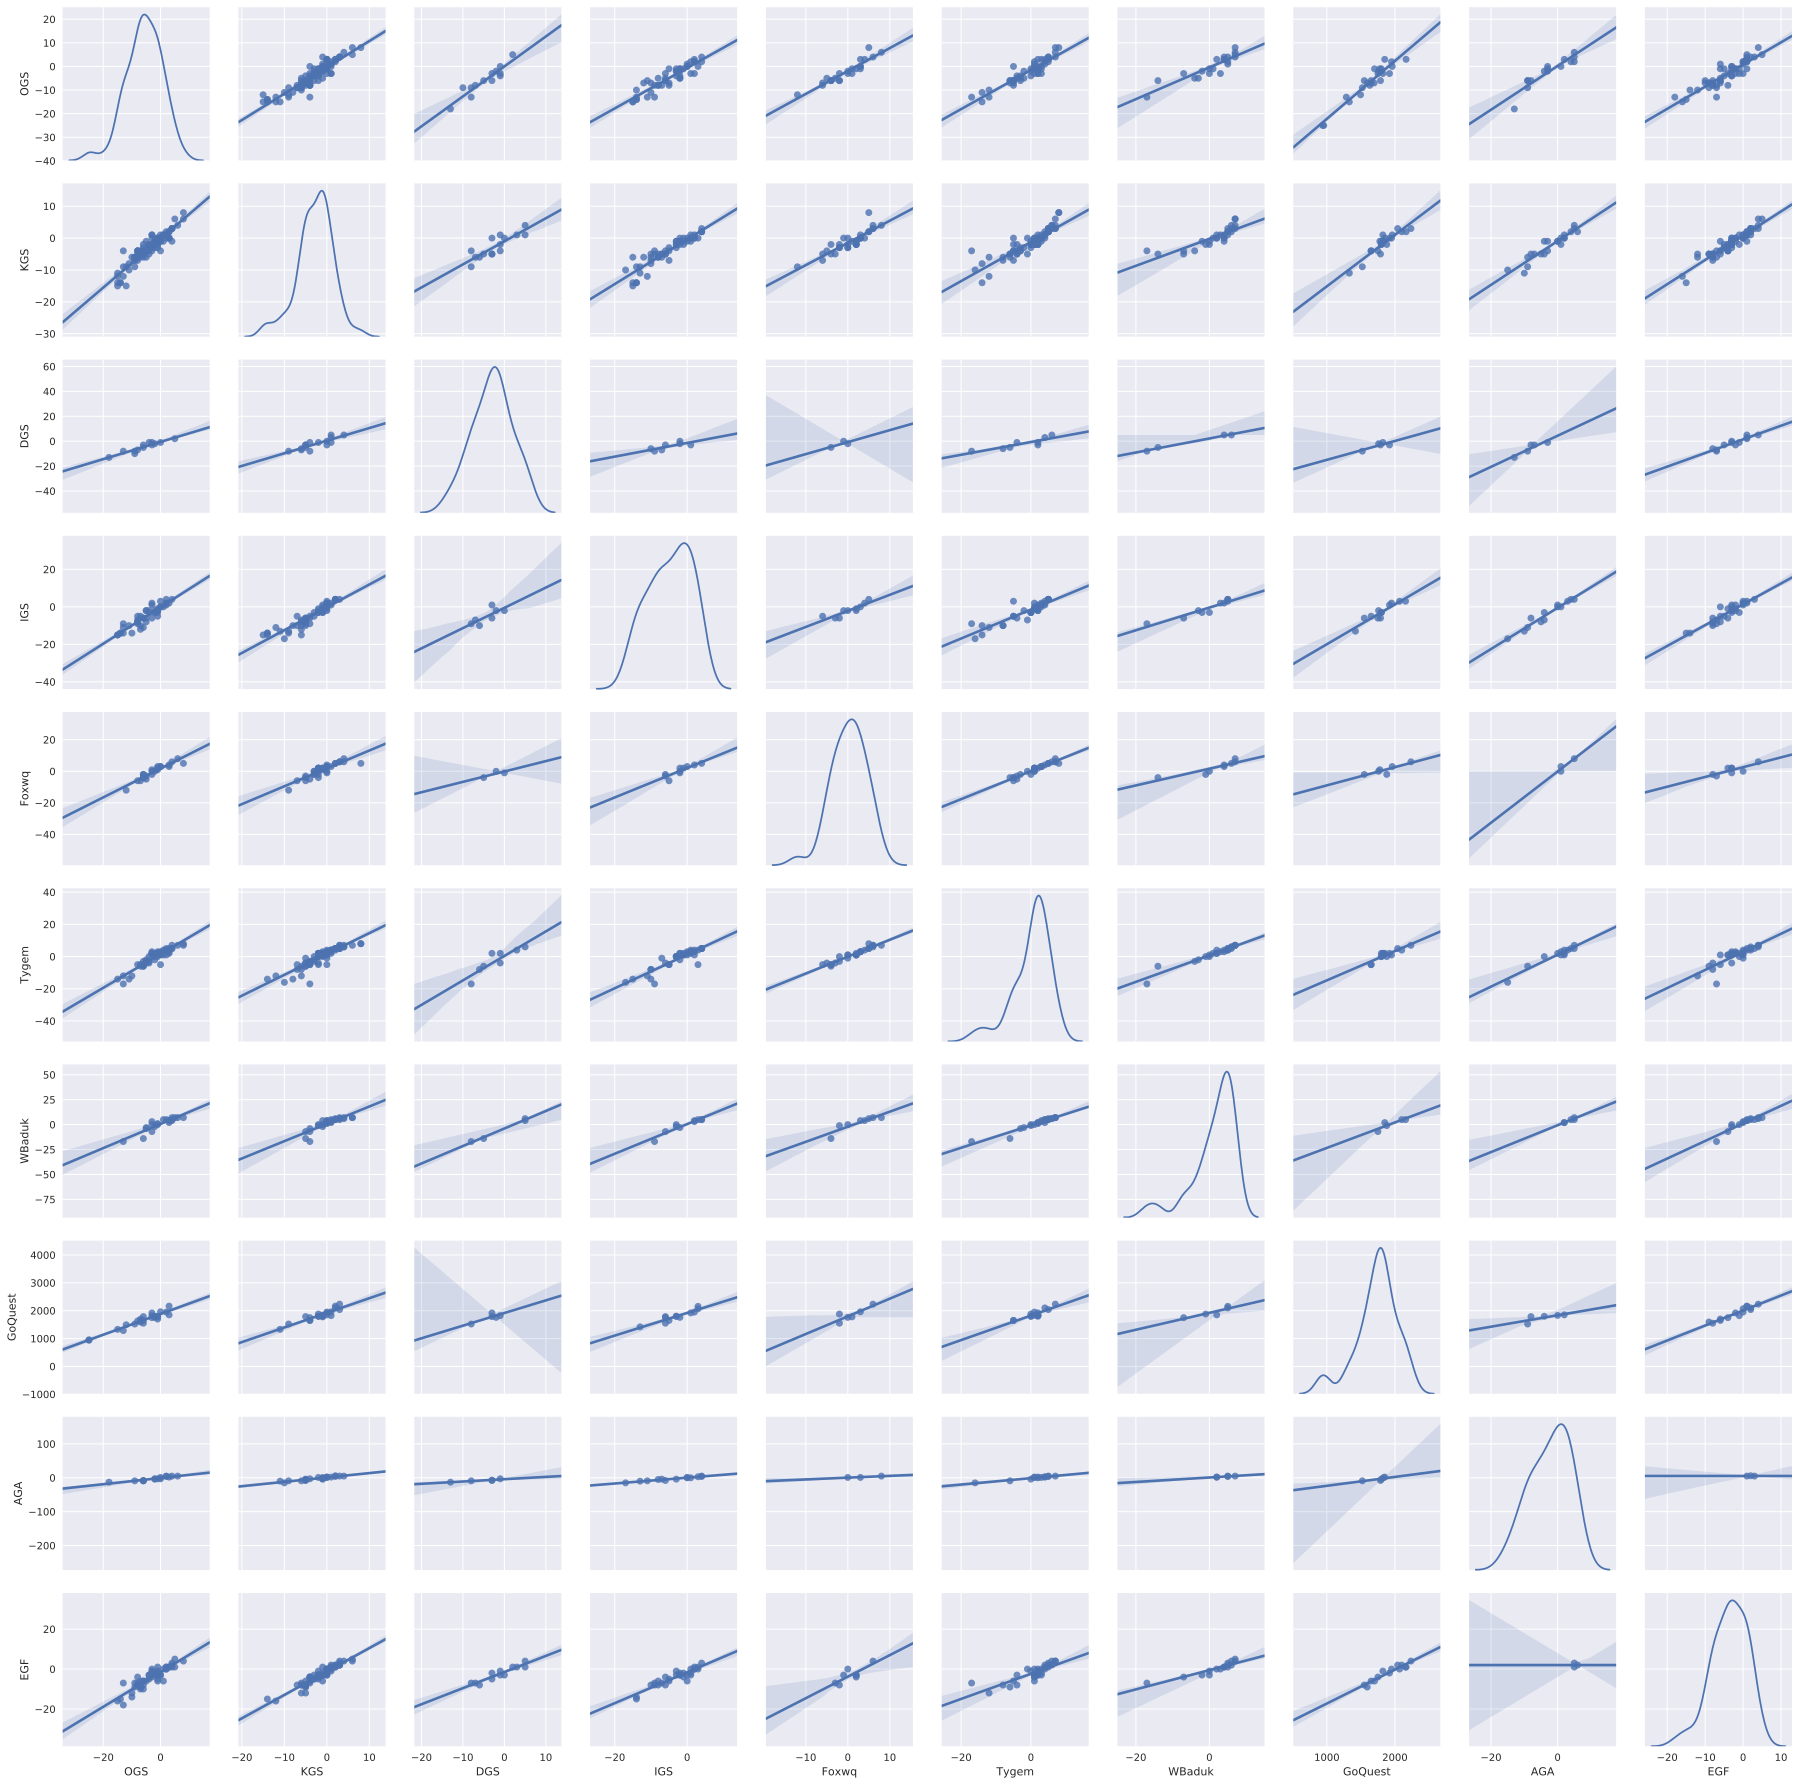

In [8]:
%%capture --no-display
sns.pairplot(X.iloc[:,((X.shape[0]-X.isna().sum())>5*3).values], diag_kind='kde', kind='reg');

In [9]:
def plot(m, X, Y, lo=-20, hi=10, xlabel='X', ylabel='Y', sigma=2):
    lo = X.min()-abs(X.min()*.5/2)
    hi = X.max()+abs(X.max()*.5)
    xx = np.linspace(lo, hi, 1000)[:,None]
    mean, var = m.predict_y(xx)
    p=plt.figure()#figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - sigma*np.sqrt(var[:,0]), mean[:,0] + sigma*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(lo, hi)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p
#plot(m, x.T[0], x.T[1])
#sns.regplot(x.T[0], x.T[1])

In [10]:
def get_ranks_on_server(rank_start=-15, rank_end=7, fro='OGS', to='Tygem', lo=-20, hi=10, k=gp.kernels.RBF, meanf=gp.mean_functions.Zero, prior=(10,1e9), sigma=2):
    x=X[[fro,to,]].dropna().values
    ranks = sc.arange(rank_start, rank_end)
    with gp.defer_build():
        m=gp.models.GPR(X=x.T[0].reshape(-1, 1), Y=x.T[1].reshape(-1, 1), kern=k(1), mean_function=meanf())
        m.kern.lengthscales.prior = gp.priors.Gaussian(*prior)
    m.compile()
    gp.train.ScipyOptimizer(tol=1e-7).minimize(m)
    print('\n'+to)
    print(m.kern.lengthscales)
    mean, var = m.predict_y(ranks[:,None])
    return mean,(mean[:,0] - sigma*np.sqrt(var[:,0]), mean[:,0] + sigma*np.sqrt(var[:,0])), plot(m, x.T[0], x.T[1], lo=lo, hi=hi, xlabel=fro, ylabel=to, sigma=sigma)

In [11]:
def fillna(a='OGS', b='KGS'):
    with gp.defer_build():
        m=gp.models.GPR(X=X[[a,b]].dropna()[a].values[:,None], Y=X[[a,b]].dropna()[b].values[:,None], kern=gp.kernels.RBF(1), mean_function=gp.mean_functions.Linear())
        #m.kern.lengthscales.prior = gp.priors.Gaussian(10,10)
    m.compile()
    gp.train.ScipyOptimizer().minimize(m)
    xx=X[X[a].notna()&X[b].isna()][a].values[:,None]
    yy=m.predict_y(xx)[0]
    print(yy.shape)
    X.loc[X[a].notna()&X[b].isna(), b] = yy.ravel()

In [12]:
%%capture
cols = sorted(X.columns, key=lambda x: X[x].count(), reverse=True)
for c in [x for x in sorted(X.columns, key=lambda x: X[x].count(), reverse=True) if x!='OGS']:
    #fillna('MIX',c)
    fillna(c,'OGS')

In [13]:
def n_to_rank(n):
    if n>500:
        return int(round(n))
    n=int(round(n))
    if n<0:
        return f'{abs(n)}k'
    else:
        return f'{abs(n+1)}d'

In [14]:
def n_to_rank_float(n):
    if n>500:
        return round(n,1)
    n=round(n,1)
    if n<0:
        return f'{abs(n)}k'
    else:
        return f'{abs(n+1)}d'

In [15]:
def get_rank_tables(against='KGS', lo=-15, hi=7, prior=(10,1e6)):
    meantable = pd.DataFrame()
    stdtable = pd.DataFrame()
    combinedtable = pd.DataFrame()
    for s in X.drop(columns=[against,]).columns:
        mean,ci,p = get_ranks_on_server(
            lo,
            hi,
            against,
            s,
            k=lambda x: gp.kernels.RBF(1),
            meanf=gp.mean_functions.Linear,
            prior=prior,
            sigma=1,
        )
        meantable.insert(loc=0, column=s, value=[f'{n_to_rank(mean[x][0])}' for x,_ in enumerate(mean)])
        stdtable.insert(loc=0, column=s, value=[f'{n_to_rank(ci[0][x])} - {n_to_rank(ci[1][x])}' for x,_ in enumerate(ci[0])])
        combinedtable.insert(loc=0, column=s, value=[f'{n_to_rank_float(mean[x][0])} ± {round(ci[1][x]-mean[x][0],1)}' for x,_ in enumerate(mean)])
    meantable.insert(loc=0, column=against, value=[f'{n_to_rank(x)}' for x in sc.arange(lo,hi)])
    stdtable.insert(loc=0, column=against, value=[f'{n_to_rank(x)}' for x in sc.arange(lo,hi)])
    combinedtable.insert(loc=0, column=against, value=[f'{n_to_rank(x)}' for x in sc.arange(lo,hi)])
    return meantable, stdtable, combinedtable

## GP regressions used for the following rank tables

The following plots are mainly for visually demonstrating the imprecision of the following estimates.

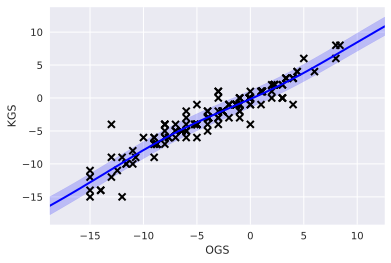

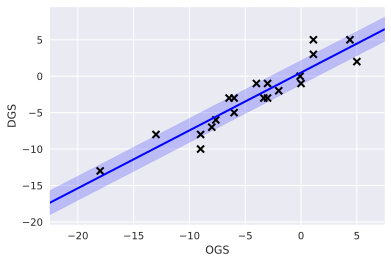

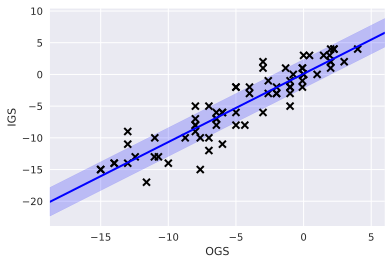

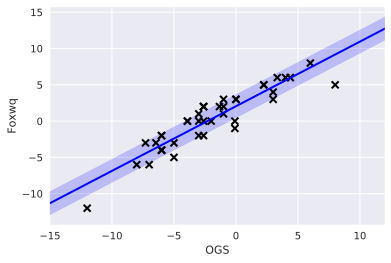

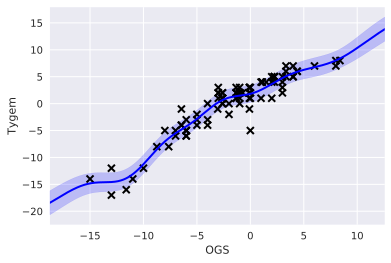

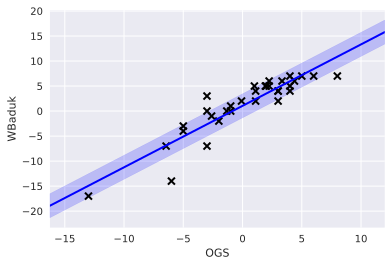

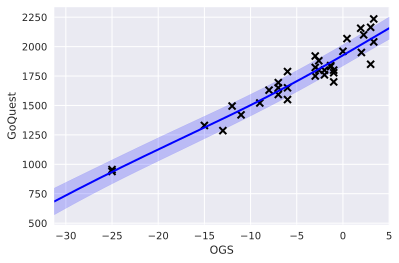

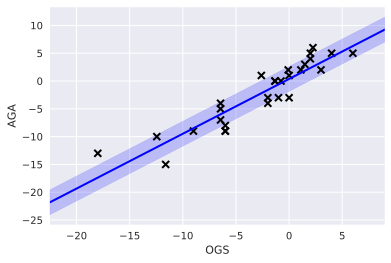

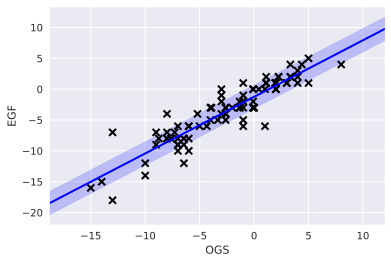

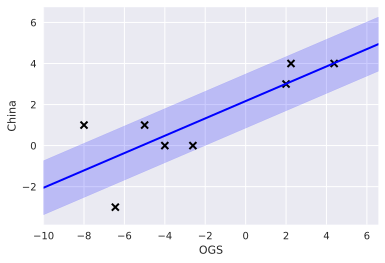

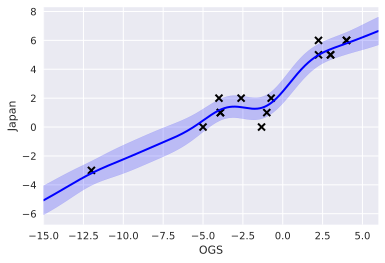

In [16]:
%%capture --no-display
a='OGS'
mt1,st1,ct1=get_rank_tables(against=a, prior=(10,10-2))

In [17]:
cols = ['KGS','OGS','IGS','DGS','Tygem','Foxwq','WBaduk','GoQuest','EGF','AGA','Japan','China',]

## A table of rounded mean ranks

In [18]:
mt1[cols].set_index(a)

,KGS,IGS,DGS,Tygem,Foxwq,WBaduk,GoQuest,EGF,AGA,Japan,China
OGS,,,,,,,,,,,
15k,13k,16k,11k,15k,11k,17k,1312,15k,14k,5k,4k
14k,12k,15k,11k,15k,10k,16k,1350,14k,13k,4k,4k
13k,11k,14k,10k,15k,10k,15k,1387,13k,12k,4k,3k
12k,10k,13k,9k,14k,9k,14k,1425,12k,11k,3k,3k
11k,9k,12k,8k,13k,8k,12k,1464,11k,10k,3k,2k
10k,8k,11k,7k,11k,7k,11k,1502,10k,9k,2k,2k
9k,7k,10k,7k,9k,6k,10k,1542,9k,8k,2k,2k
8k,6k,9k,6k,7k,5k,9k,1582,9k,8k,1k,1k
7k,5k,7k,5k,6k,4k,8k,1622,8k,7k,1k,1k


## A table of rounded +/- 1 standard deviation of ranks

In [19]:
st1[cols].set_index(a)

,KGS,IGS,DGS,Tygem,Foxwq,WBaduk,GoQuest,EGF,AGA,Japan,China
OGS,,,,,,,,,,,
15k,14k - 11k,18k - 14k,13k - 10k,17k - 13k,13k - 10k,20k - 15k,1217 - 1408,17k - 13k,17k - 12k,6k - 4k,5k - 3k
14k,13k - 11k,17k - 13k,12k - 9k,16k - 13k,12k - 9k,19k - 14k,1255 - 1444,16k - 12k,16k - 11k,5k - 3k,5k - 2k
13k,12k - 10k,16k - 12k,11k - 8k,16k - 13k,11k - 8k,17k - 13k,1294 - 1481,15k - 11k,15k - 10k,5k - 3k,5k - 2k
12k,11k - 9k,15k - 11k,11k - 7k,16k - 12k,10k - 7k,16k - 11k,1332 - 1518,14k - 10k,14k - 9k,4k - 2k,4k - 2k
11k,10k - 8k,14k - 9k,10k - 7k,15k - 11k,9k - 6k,15k - 10k,1371 - 1556,13k - 9k,13k - 8k,4k - 2k,4k - 1k
10k,9k - 7k,13k - 8k,9k - 6k,13k - 10k,8k - 5k,14k - 9k,1411 - 1594,12k - 8k,12k - 7k,3k - 1k,3k - 1k
9k,8k - 6k,12k - 7k,8k - 5k,11k - 7k,8k - 4k,12k - 8k,1451 - 1633,11k - 8k,11k - 6k,3k - 1k,3k - 1d
8k,7k - 5k,11k - 6k,8k - 4k,9k - 5k,7k - 3k,11k - 6k,1491 - 1673,10k - 7k,10k - 5k,2k - 1d,3k - 1d
7k,7k - 4k,10k - 5k,7k - 3k,7k - 4k,6k - 3k,10k - 5k,1532 - 1713,10k - 6k,9k - 4k,2k - 1d,2k - 2d


## A combined table of mean and standard deviation of ranks

In [20]:
ct1[cols].set_index(a)

,KGS,IGS,DGS,Tygem,Foxwq,WBaduk,GoQuest,EGF,AGA,Japan,China
OGS,,,,,,,,,,,
15k,12.8k ± 1.3,16.0k ± 2.3,11.4k ± 1.7,14.8k ± 1.9,11.3k ± 1.6,17.4k ± 2.4,1312.3 ± 95.3,15.0k ± 1.9,14.4k ± 2.2,5.1k ± 1.0,4.2k ± 1.3
14k,11.8k ± 1.3,15.0k ± 2.3,10.6k ± 1.7,14.6k ± 1.8,10.4k ± 1.6,16.2k ± 2.4,1349.6 ± 94.5,14.1k ± 1.9,13.4k ± 2.2,4.4k ± 1.0,3.7k ± 1.3
13k,10.8k ± 1.3,13.9k ± 2.3,9.8k ± 1.7,14.6k ± 1.7,9.5k ± 1.6,14.9k ± 2.4,1387.3 ± 93.7,13.2k ± 1.9,12.4k ± 2.2,3.8k ± 0.9,3.3k ± 1.3
12k,9.8k ± 1.3,12.8k ± 2.3,9.0k ± 1.7,14.2k ± 1.7,8.6k ± 1.6,13.7k ± 2.4,1425.2 ± 93.0,12.2k ± 1.9,11.5k ± 2.2,3.2k ± 0.8,2.9k ± 1.3
11k,8.9k ± 1.3,11.7k ± 2.3,8.2k ± 1.7,13.1k ± 1.7,7.7k ± 1.6,12.5k ± 2.4,1463.6 ± 92.3,11.3k ± 1.9,10.5k ± 2.2,2.7k ± 0.9,2.5k ± 1.3
10k,7.9k ± 1.3,10.7k ± 2.3,7.4k ± 1.7,11.3k ± 1.7,6.9k ± 1.6,11.2k ± 2.4,1502.4 ± 91.8,10.4k ± 1.9,9.5k ± 2.2,2.2k ± 1.0,2.1k ± 1.3
9k,7.0k ± 1.3,9.6k ± 2.3,6.6k ± 1.7,9.0k ± 1.7,6.0k ± 1.6,10.0k ± 2.4,1541.8 ± 91.3,9.5k ± 1.9,8.5k ± 2.2,1.8k ± 1.0,1.6k ± 1.3
8k,6.1k ± 1.3,8.5k ± 2.3,5.9k ± 1.7,7.0k ± 1.7,5.1k ± 1.6,8.8k ± 2.4,1581.8 ± 90.9,8.6k ± 1.9,7.5k ± 2.2,1.3k ± 1.0,1.2k ± 1.3
7k,5.2k ± 1.3,7.4k ± 2.3,5.1k ± 1.7,5.5k ± 1.6,4.2k ± 1.6,7.6k ± 2.4,1622.5 ± 90.6,7.7k ± 1.9,6.5k ± 2.2,0.8k ± 1.0,0.8k ± 1.3
